# General Regressions and Modeling

In [1]:
%load_ext autoreload
%autoreload 2

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import os
import sys
HOME_DIR = '/home/aysola/'
os.chdir(HOME_DIR)
sys.path.append('./NVFEL498/')

In [3]:
from Notebooks.utils import *

In [9]:
data = pd.read_csv('./NVFEL498/alltrips_vel.csv')

In [12]:
print(data.shape)

(11803, 15)


In [11]:
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,TripId,TripId_raw,VehId,Aggressivity,Aggressiveness,Distance[km],Fuel Consumed[L],Fuel Rate[gpm],Weight,Displacement,SpeedAverage,SpeedVariance
0,0,0,0,0,2265,123,475.645508,5748.696207,9.225222,0.895646,0.097087,2500.0,1.8,46.423729,147.494133
1,1,1,1,1,1239,135,269.540959,6372.966896,2.223611,0.441901,0.198731,3500.0,2.5,40.748170,447.766401
2,2,2,2,4,2263,575,266.112770,5665.167276,6.323556,1.008958,0.159556,4000.0,2.4,32.929095,247.070941
3,3,3,3,7,1681,522,552.585767,5891.611649,2.743222,0.344075,0.125427,3000.0,2.4,33.915000,447.276871
4,4,4,4,8,1375,250,529.245807,5535.915731,4.683417,0.937469,0.200168,5500.0,5.3,33.196768,319.067811


In [15]:
data['SpeedAverage'].isna().sum()

0

In [16]:
data['SpeedVariance'].isna().sum()

0

## Lets build a linear regression

In [17]:
# lets build a super simple stupid regression
from sklearn.linear_model import LinearRegression

In [246]:
# Before we can fit we have to do some preprocessing
features = ['Aggressiveness', 'Distance[km]', 'Weight', 'Displacement', 'SpeedAverage', 'SpeedVariance']
target = ['Fuel Rate[gpm]']

In [127]:
# WEIGHT HAS SOME NAN VALUES THAT ARE ENCODED AS FLOATS -- WE NEED TO USE NP.ISNAN INSTEAD OF PANDAS
# 
mask = [~(np.isnan(data.iloc[i,:]).sum()>0) for i in range(len(data))]
data = data.loc[mask]

In [212]:
X = np.array(data.loc[:,features])

In [213]:
y = np.array(data.loc[:,'Fuel Rate[gpm]']).reshape(-1,1)

In [214]:
X.shape

(11529, 6)

In [215]:
y.shape

(11529, 1)

In [216]:
model = LinearRegression().fit(X,y)

In [217]:
for feature, coef in zip(features, model.coef_[0]):
    print(f"{feature}: {coef}")

Aggressiveness: 1.188820516820224e-05
Distance[km]: -3.8248981102592604e-05
Weight: 6.059327624259096e-06
Displacement: 0.0299524660281594
SpeedAverage: 1.707837633178612e-05
SpeedVariance: 4.868811892222443e-08


In [218]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(features, model.coef_[0])):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(model.coef_[0])])
for feature, i in zip(features, (impact*100)/impact.sum()):
    print(f"{feature}: {i}")

Impact = MEAN * Coef
Aggressiveness: 0.06184528612055701
Distance[km]: -0.00020453144069008174
Weight: 0.020393534577180465
Displacement: 0.07506926104927253
SpeedAverage: 0.0006729971659087428
SpeedVariance: 2.4989540075156042e-05
========= PERCENTAGES =========
Aggressiveness: 39.090482029722686
Distance[km]: 0.12927796293517937
Weight: 12.890118987529737
Displacement: 47.44894532965449
SpeedAverage: 0.4253805790263045
SpeedVariance: 0.015795111131585857


In [219]:
# now lets compute r^2:
preds = model.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()

In [220]:
r_2

0.6123278886732875

In [221]:
# now lets draw our plots:

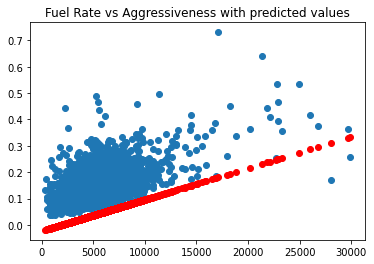

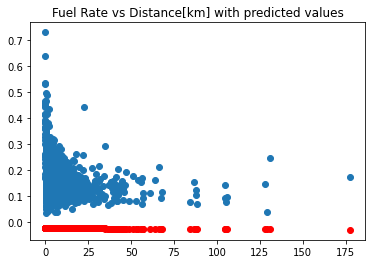

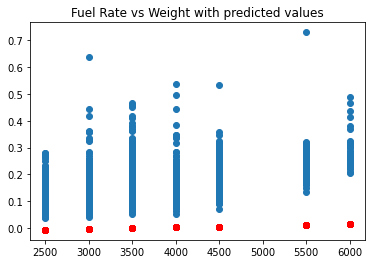

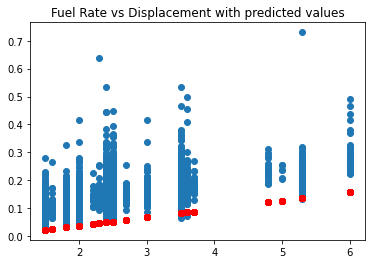

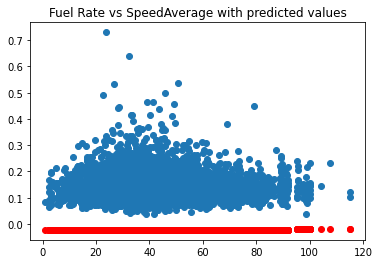

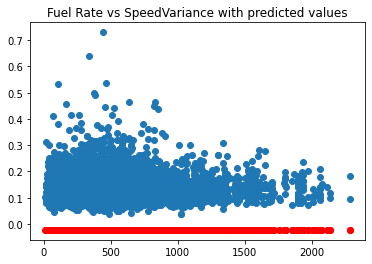

In [224]:
# single value predictions
for i, feature in enumerate(features):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], model.coef_[0][i]*X[:,i] + model.intercept_[0], color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

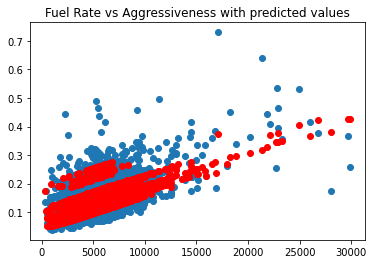

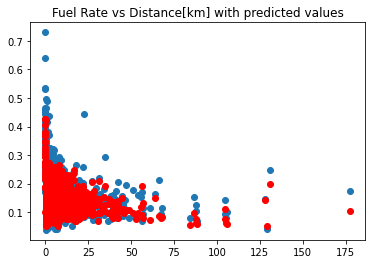

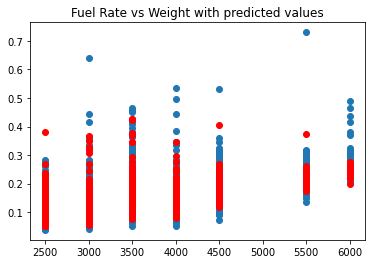

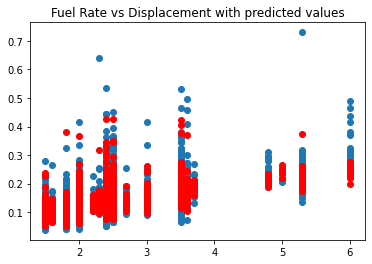

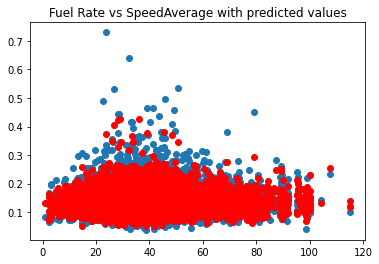

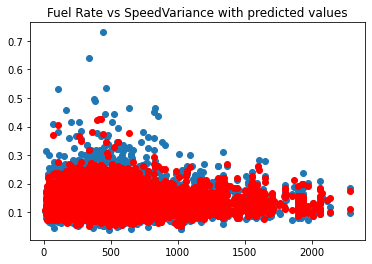

In [225]:
#plotting full model values
for i, feature in enumerate(features):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], preds, color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

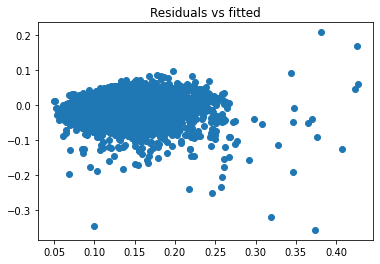

In [226]:
# lets plot our residuals:
residuals = (preds - y)
plt.scatter(preds, residuals)
plt.title('Residuals vs fitted')
plt.show()

## Adding Some Interaction Variables

In [227]:
# thats not a particuarly compelling plot -- lets add some interaction variables to our set:
for i, f in enumerate(features):
    print(f"{i} : {f}")

0 : Aggressiveness
1 : Distance[km]
2 : Weight
3 : Displacement
4 : SpeedAverage
5 : SpeedVariance


Lets iteract the following variables:

`Aggressiveness` and `SpeedAverage`

`Aggressiveness` and `Distance[km]`

`Displacement` and `1/Weight` => power to weight


In [228]:
X.shape

(11529, 6)

In [229]:
X = np.append(X, (X[:,0] * X[:,4]).reshape(-1,1), 1) #aggr and avespeed
X = np.append(X, (X[:,0] * X[:,3]).reshape(-1,1), 1) # aggr and distance
X = np.append(X, (X[:,3] / X[:,2]).reshape(-1,1), 1) # displ and 1/weight

In [230]:
X.shape

(11529, 9)

In [231]:
#lets update our feature list
interaction_features = features + ['Aggr*AveSpeed', 'Aggr*Distance', 'Displ/Weight']

In [232]:
# lets fit our model again:
model = LinearRegression().fit(X,y)

In [233]:
for feature, coef in zip(interaction_features, model.coef_[0]):
    print(f"{feature}: {coef}")

Aggressiveness: 4.109603391407518e-06
Distance[km]: 1.7205819257853772e-05
Weight: -9.172978419857352e-06
Displacement: 0.03477552361547563
SpeedAverage: -5.035984700663981e-05
SpeedVariance: 1.9055986521698432e-07
Aggr*AveSpeed: 1.2604850684488406e-08
Aggr*Distance: 2.9460774284102315e-06
Displ/Weight: -70.59826830183906


In [234]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(interaction_features, model.coef_[0])):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(model.coef_[0])])
for feature, i in zip(interaction_features, (impact*100)/impact.sum()):
    print(f"{feature}: {i}")

Impact = MEAN * Coef
Aggressiveness: 0.021379139574695276
Distance[km]: 9.200587570222754e-05
Weight: -0.030872972082272087
Displacement: 0.08715719293232776
SpeedAverage: -0.001984499793928708
SpeedVariance: 9.780627171411371e-05
Aggr*AveSpeed: 0.00258460756699648
Aggr*Distance: 0.038407058144407265
Displ/Weight: -0.052105052045205595
========= PERCENTAGES =========
Aggressiveness: 9.10989821095411
Distance[km]: 0.03920476591345401
Weight: 13.15532985583848
Displacement: 37.138686203526134
SpeedAverage: 0.8456182747292637
SpeedVariance: 0.04167638162403438
Aggr*AveSpeed: 1.1013311255270803
Aggr*Distance: 16.365690913579872
Displ/Weight: 22.202564268307555


In [235]:
# now lets compute r^2:
# WOW WE have an almost 0 impact on r^2 -- surprising
preds = model.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()
print(r_2)

0.6200223135986707


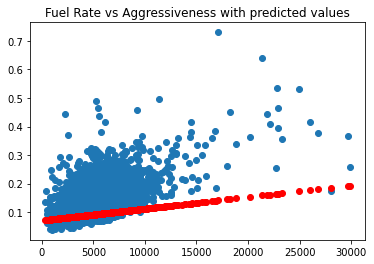

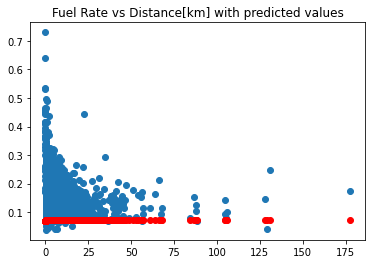

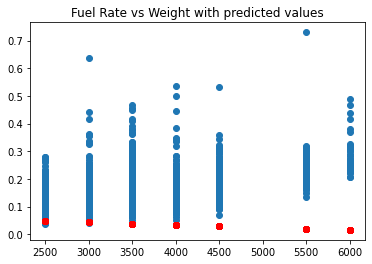

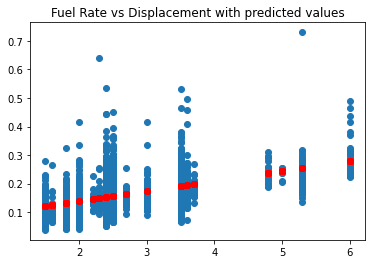

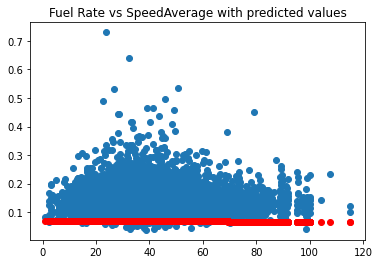

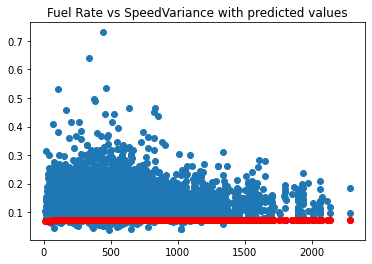

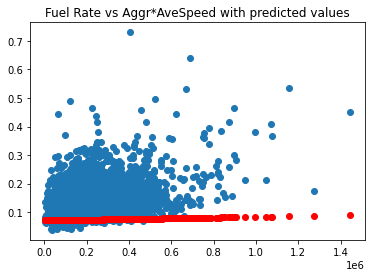

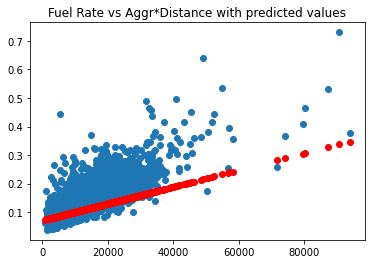

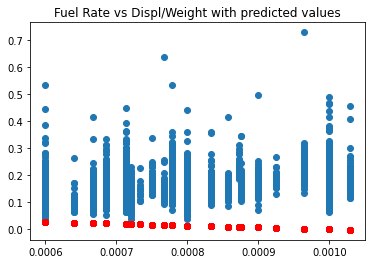

In [236]:
# single value predictions
for i, feature in enumerate(interaction_features):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], model.coef_[0][i]*X[:,i] + model.intercept_[0], color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

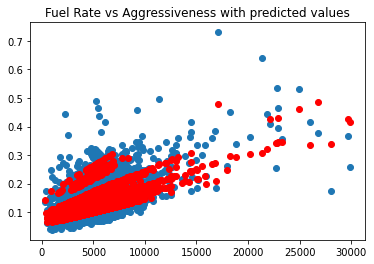

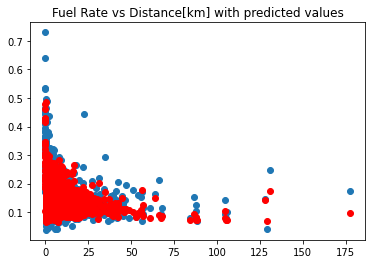

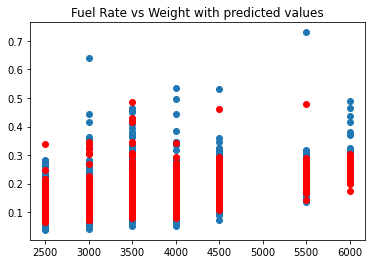

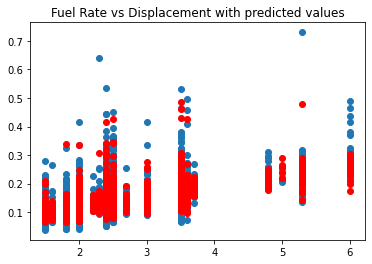

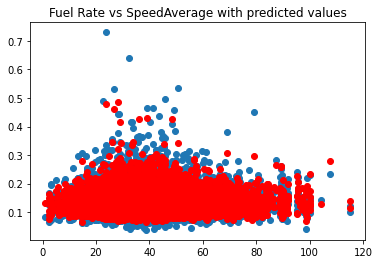

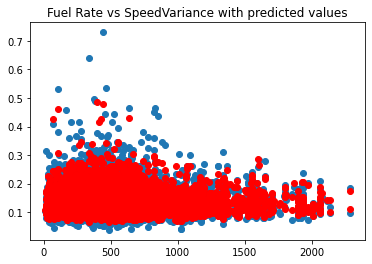

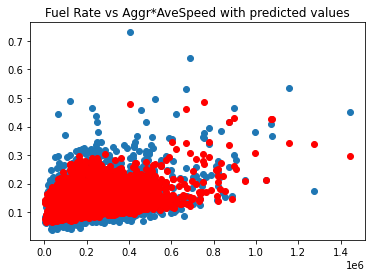

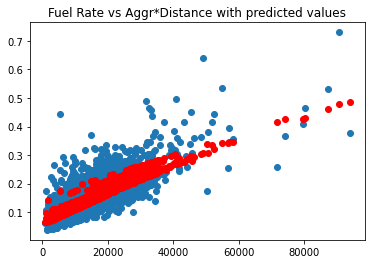

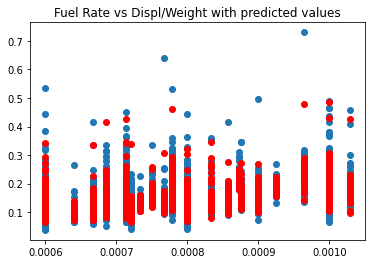

In [238]:
#plotting full model values
for i, feature in enumerate(interaction_features):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], preds, color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

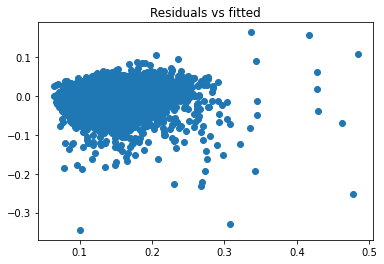

In [239]:
# resuidual vs fitted plots!
residuals = (preds - y)
plt.scatter(preds, residuals)
plt.title('Residuals vs fitted')
plt.show() # we have the same issue with this plot where our residuals vs fitted are still clumpy

## Lets run a larger interaction variable test:

In [255]:
# reset the data 
X = np.array(data.loc[:, features])
y = np.array(data.loc[:,target]).reshape(-1,1)

In [256]:
X.shape

(11529, 6)

In [257]:
y.shape

(11529, 1)

In [258]:
# lets make all the interaction variables:
all_interaction = features.copy()
for i in range(len(features)):
    for j in range(i+1, len(features)):
        X = np.append(X, (X[:, i] * X[:, j]).reshape(-1,1), 1)
        all_interaction.append(f"{features[i]}*{features[j]}")

In [259]:
all_interaction

['Aggressiveness',
 'Distance[km]',
 'Weight',
 'Displacement',
 'SpeedAverage',
 'SpeedVariance',
 'Aggressiveness*Distance[km]',
 'Aggressiveness*Weight',
 'Aggressiveness*Displacement',
 'Aggressiveness*SpeedAverage',
 'Aggressiveness*SpeedVariance',
 'Distance[km]*Weight',
 'Distance[km]*Displacement',
 'Distance[km]*SpeedAverage',
 'Distance[km]*SpeedVariance',
 'Weight*Displacement',
 'Weight*SpeedAverage',
 'Weight*SpeedVariance',
 'Displacement*SpeedAverage',
 'Displacement*SpeedVariance',
 'SpeedAverage*SpeedVariance']

In [260]:
X.shape

(11529, 21)

In [261]:
model = LinearRegression().fit(X, y)

In [264]:
for feature, coef in zip(all_interaction, model.coef_[0]):
    print(f"{feature}: {coef}")

Aggressiveness: 2.5022926173706823e-06
Distance[km]: 0.0003009805061247783
Weight: -1.1893202490620523e-05
Displacement: 0.010147303150106018
SpeedAverage: 6.144613174886634e-05
SpeedVariance: 1.974361128572301e-07
Aggressiveness*Distance[km]: -3.8251066330590243e-07
Aggressiveness*Weight: 1.7675447132677472e-09
Aggressiveness*Displacement: 1.6223401111833852e-06
Aggressiveness*SpeedAverage: 1.7993876257149626e-08
Aggressiveness*SpeedVariance: -6.893053204528441e-10
Distance[km]*Weight: 3.375073559130909e-07
Distance[km]*Displacement: -0.00022565392091916604
Distance[km]*SpeedAverage: 5.175361508629751e-06
Distance[km]*SpeedVariance: -1.7215678674891726e-09
Weight*Displacement: 3.2538600924069544e-06
Weight*SpeedAverage: -1.4078378054548045e-08
Weight*SpeedVariance: 4.779569972704856e-10
Displacement*SpeedAverage: -3.919495876954216e-05
Displacement*SpeedVariance: 1.8208014369773895e-06
SpeedAverage*SpeedVariance: -4.7788005972552274e-08


In [265]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(all_interaction, model.coef_[0])):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(model.coef_[0])])
for feature, i in zip(all_interaction, (impact*100)/impact.sum()):
    print(f"{feature}: {i}")

Impact = MEAN * Coef
Aggressiveness: 0.01301752457070437
Distance[km]: 0.0016094540236826912
Weight: -0.04002827562167602
Displacement: 0.02543198107311982
SpeedAverage: 0.002421370259072949
SpeedVariance: 0.00010133555708755586
Aggressiveness*Distance[km]: -0.009542428587891507
Aggressiveness*Weight: 0.031002679734935045
Aggressiveness*Displacement: 0.021149923073762494
Aggressiveness*SpeedAverage: 0.003689619964404585
Aggressiveness*SpeedVariance: -0.0018368910594713528
Distance[km]*Weight: 0.006168451356207922
Distance[km]*Displacement: -0.003084888067653157
Distance[km]*SpeedAverage: 0.0010893730424327756
Distance[km]*SpeedVariance: -4.766858874831378e-06
Weight*Displacement: 0.02881071700321241
Weight*SpeedAverage: -0.001866221008820074
Weight*SpeedVariance: 0.0008241984075872981
Displacement*SpeedAverage: -0.0038689221787572207
Displacement*SpeedVariance: 0.0023391801100916274
SpeedAverage*SpeedVariance: -0.0010369376461777547
========= PERCENTAGES =========
Aggressiveness: 6.543

In [266]:
# now lets compute r^2:
# WOW WE have an almost 0 impact on r^2 -- surprising
preds = model.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()
print(r_2)

0.634915533525551


## Optimizing our Linear Regression with Smart Variable Choices